# Price base policy: price elasticity of carbon in GCAM

In [1]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [2]:
#define main directory
mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'

We measure both price and quantities, then stack them together as a table.

In [3]:
color = 'blue' #for GCAM

In [4]:
FOSlist = [u'Bus',u'coal',u'coal gasification',u'coal to liquids',u'Compact Car',u'Domestic Aviation',u'Domestic Ship',\
           u'Freight Rail',u'gas',u'gas pipeline',u'gas to liquids',u'International Aviation',u'International Ship',\
           u'Large Car',u'Light Truck and SUV',u'Midsize Car',u'Motorcycle (>250cc)',u'oil refining',u'Passenger Rail',\
           u'refined liquids',u'Truck (>12t)',u'Truck (0-2.7t)',u'Truck (2.7-4.5t)',u'Truck (4.5-12t)',\
           u'unconventional oil production',u'3W Rural',u'Heavy Bus',u'Light Bus',u'Mini Car',u'Moped',u'Motorcycle (50-250cc)',\
           u'Multipurpose Vehicle',u'Scooter',u'Subcompact Car',u'Three-Wheeler',u'Truck',u'Truck (>14t)',u'Truck (>15t)',\
           u'Truck (>32t)',u'Truck (0-1t)',u'Truck (0-2t)',u'Truck (0-3.5t)',u'Truck (0-4.5t)',u'Truck (0-6t)',u'Truck (16-32t)',\
           u'Truck (1-6t)',u'Truck (2-5t)',u'Truck (3.5-16t)',u'Truck (4.5-15t)',u'Truck (5-9t)',u'Truck (6-14t)',\
           u'Truck (6-15t)',u'Truck (6-30t)',u'Truck (9-16t)',u'Van']
FIlist = FOSlist + [u'cement']
TOTlist = FIlist + [u'biomass',u'biomass gasification',u'biomass liquids',u'regional biomass',u'regional biomassOil',\
                        u'regional corn for ethanol',u'regional sugar for ethanol','land-use']

In [5]:
len(FOSlist),len(FIlist),len(TOTlist)

(55, 56, 64)

In [6]:
#define function to read price out (from previous note)
def pmeasure_gcam(CarbonAccounting, PricePath, perturb):
    filename = 'co2price_' + PricePath + '_' + perturb + '.xlsx'
    #read from GCAM4.0 result
    co2price = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/' + CarbonAccounting +'/' + filename, sheetname="Sheet1")

    co2price.drop(['scenario','market','Units'],axis=1,inplace=True)
    #need this for GCAM4.0 result (double price lines)
    if co2price.shape[1]==2:
        co2price.drop(co2price.index[[1]],inplace=True)
    co2price.set_index('region',inplace=True)
    co2price = pd.DataFrame(co2price.stack()).reset_index()
    co2price.columns = ['region','year','price']
    co2price['price'] = co2price['price']*12/44/0.72262 #unit conversion to 2005 dollars per CO2 ton

    p = co2price[co2price.region=='Global'][['year','price']]
    p.set_index('year',inplace=True)
    p.columns = [perturb]
    return p;

#define function to read quantities out (from previous note)
def qmeasure_gcam(CarbonAccounting, PricePath, perturb):
    #Define types of carbon emission for GCAM3.2
    '''
    FOSlist = [u'LDV', u'air', u'bus', u'coal', u'coal chemical', u'coal gasification', u'coal to liquids', u'domestic ship', u'gas',\
     u'gas chemical', u'gas pipeline', u'gas to liquids', u'international ship', u'oil', u'oil refining', u'rail', u'refined liquids',\
     u'road', u'unconventional oil production']
    FIlist = FOSlist + [u'cement' (conv)']
    TOTlist = FIlist + [u'biomass', u'biomass gasification',  u'biomass liquids', u'biomass to H2','land-use',u'regional biomass',\
     u'regional biomassOil', u'regional corn for ethanol', u'regional sugar for ethanol', u'regional sugarbeet for ethanol']
     '''
    #GCAM4.0
    FOSlist = [u'Bus',u'coal',u'coal gasification',u'coal to liquids',u'Compact Car',u'Domestic Aviation',u'Domestic Ship',\
           u'Freight Rail',u'gas',u'gas pipeline',u'gas to liquids',u'International Aviation',u'International Ship',\
           u'Large Car',u'Light Truck and SUV',u'Midsize Car',u'Motorcycle (>250cc)',u'oil refining',u'Passenger Rail',\
           u'refined liquids',u'Truck (>12t)',u'Truck (0-2.7t)',u'Truck (2.7-4.5t)',u'Truck (4.5-12t)',\
           u'unconventional oil production',u'3W Rural',u'Heavy Bus',u'Light Bus',u'Mini Car',u'Moped',u'Motorcycle (50-250cc)',\
           u'Multipurpose Vehicle',u'Scooter',u'Subcompact Car',u'Three-Wheeler',u'Truck',u'Truck (>14t)',u'Truck (>15t)',\
           u'Truck (>32t)',u'Truck (0-1t)',u'Truck (0-2t)',u'Truck (0-3.5t)',u'Truck (0-4.5t)',u'Truck (0-6t)',u'Truck (16-32t)',\
           u'Truck (1-6t)',u'Truck (2-5t)',u'Truck (3.5-16t)',u'Truck (4.5-15t)',u'Truck (5-9t)',u'Truck (6-14t)',\
           u'Truck (6-15t)',u'Truck (6-30t)',u'Truck (9-16t)',u'Van']
    FIlist = FOSlist + [u'cement']
    TOTlist = FIlist + [u'biomass',u'biomass gasification',u'biomass liquids',u'regional biomass',u'regional biomassOil',\
                        u'regional corn for ethanol',u'regional sugar for ethanol','land-use']

    #Global
    #this is for land use change emission
    filename = 'global_landuse_' +PricePath + '_' + perturb + '.xlsx'
    table1 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ CarbonAccounting +'/'  + filename, sheetname="Sheet1")
    table1.drop(['scenario','region','land-use-change-emission','Units',1980,1985,1995,2000],axis=1, inplace=True)
    table1['subsector'] = ['land-use']

    #this is for other emission
    filename = 'global_subsector_' +PricePath + '_' + perturb + '.xlsx'
    table2 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ CarbonAccounting +'/'  + filename, sheetname="Sheet1")
    table2.drop(['scenario','region','sector','Units'],axis=1, inplace=True)

    table = pd.concat([table1,table2])
    global_table = table

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in FOSlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qglobal_fos = d

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in FIlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qglobal_fi = d

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in TOTlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qglobal_tot = d

    #US
    #this is for land use change emission
    filename = 'us_landuse_' + PricePath + '_' + perturb + '.xlsx'
    table1 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ CarbonAccounting +'/'  + filename, sheetname="Sheet1")
    table1.drop(['scenario','region','land-use-change-emission','Units',1980,1985,1995,2000],axis=1, inplace=True)
    table1['subsector'] = ['land-use']

    #this is for other emission
    filename = 'us_subsector_' + PricePath + '_' + perturb + '.xlsx'
    table2 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ CarbonAccounting +'/'  + filename, sheetname="Sheet1")
    table2.drop(['scenario','region','sector','Units'],axis=1, inplace=True)

    table = pd.concat([table1,table2])

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in FOSlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qUS_fos = d

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in FIlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qUS_fi = d

    d =pd.DataFrame(table[table.subsector.map(lambda x: x in TOTlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
    d.columns = ['year','level']
    d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    qUS_tot = d
    
    qUS_fos.set_index('year',inplace=True)
    qUS_fos.columns = [perturb]
    
    qglobal_fos.set_index('year',inplace=True)
    qglobal_fos.columns = [perturb]
    
    qUS_fi.set_index('year',inplace=True)
    qUS_fi.columns = [perturb]
    
    qglobal_fi.set_index('year',inplace=True)
    qglobal_fi.columns = [perturb]
    
    qUS_tot.set_index('year',inplace=True)
    qUS_tot.columns = [perturb]
    
    qglobal_tot.set_index('year',inplace=True)
    qglobal_tot.columns = [perturb]
    
    return qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos;

## Accounting all carbon emission (TOT)

First batch to account all carbon in tax is here. 

In [7]:
CarbonAccounting = 'price-based-tot' # 'price' vs. 'quantity' and tot' vs. 'fos'

def constructpq_table(PricePath):
    ptable = pd.DataFrame()
    qUS_tot_table = pd.DataFrame()
    qglobal_tot_table = pd.DataFrame()
    qUS_fi_table = pd.DataFrame()
    qglobal_fi_table = pd.DataFrame()
    qUS_fos_table = pd.DataFrame()
    qglobal_fos_table = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        p = pmeasure_gcam(CarbonAccounting, PricePath, perturb)
        ptable = pd.concat([ptable,p],axis=1)
        qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos = qmeasure_gcam(CarbonAccounting, PricePath, perturb)
        qUS_tot_table = pd.concat([qUS_tot_table,qUS_tot],axis=1)
        qglobal_tot_table = pd.concat([qglobal_tot_table,qglobal_tot],axis=1)
        qUS_fi_table = pd.concat([qUS_fi_table,qUS_fi],axis=1)
        qglobal_fi_table = pd.concat([qglobal_fi_table,qglobal_fi],axis=1)
        qUS_fos_table = pd.concat([qUS_fos_table,qUS_fos],axis=1)
        qglobal_fos_table = pd.concat([qglobal_fos_table,qglobal_fos],axis=1)
    return ptable, qUS_tot_table, qglobal_tot_table,qUS_fi_table, qglobal_fi_table, qUS_fos_table, qglobal_fos_table;

p_step050, qUS_tot_step050, qglobal_tot_step050, qUS_fi_step050, qglobal_fi_step050, qUS_fos_step050, qglobal_fos_step050 = constructpq_table('step050')
p_step100, qUS_tot_step100, qglobal_tot_step100, qUS_fi_step100, qglobal_fi_step100, qUS_fos_step100, qglobal_fos_step100 = constructpq_table('step100')
p_step200, qUS_tot_step200, qglobal_tot_step200, qUS_fi_step200, qglobal_fi_step200, qUS_fos_step200, qglobal_fos_step200 = constructpq_table('step200')


Here we plot all types of carbon emission with different perturbations under different step prices. Black represent total carbon emission and red represents fossil fuel carbon emission.

(0, 100000)

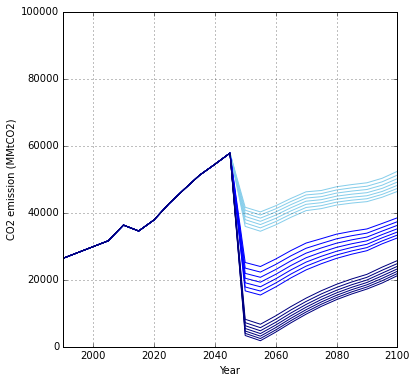

In [8]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = qglobal_tot_step050
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='skyblue',linestyle='-')
df1 = qglobal_tot_step100
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='blue',linestyle='-')
df1 = qglobal_tot_step200
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='navy',linestyle='-')
ax1.set_ylabel('CO2 emission (MMtCO2)')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

In [9]:
def accumulated_elasticity(p,q):
    x = np.log10(np.array(p[p.index>=2050]))[0]
    #y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
    y = np.log10(np.array(q[q.index>=2050].sum(axis=0)))
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    l = [results.params[1]]+list(results.conf_int()[1])
    return [l[0],(l[2]-l[1])*0.5];

In [10]:
def constructelasticity_table(p,q):
    elasticity_table = pd.DataFrame(columns = ('year','value','lower','upper'))
    yearlist = [2050, 2060, 2070, 2080, 2090, 2100]
    for i in range(0,len(yearlist)):
        x = np.log10(np.array(p[p.index==yearlist[i]]))[0]
        y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
        X = sm.add_constant(x)
        model = sm.OLS(y, X)
        results = model.fit()
        elasticity_table.loc[i] = [yearlist[i], results.params[1]]+list(results.conf_int()[1])
    return elasticity_table;

(-4, 0)

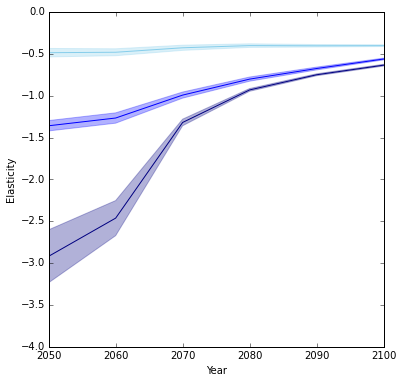

In [11]:
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_step050,qglobal_tot_step050)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='skyblue')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='skyblue', alpha=0.3)   
elasticity_table = constructelasticity_table(p_step100,qglobal_tot_step100)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='blue')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='blue', alpha=0.3)  
elasticity_table = constructelasticity_table(p_step200,qglobal_tot_step200)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='navy')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='navy', alpha=0.3)          
ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)


In [13]:
accumulated_elasticity(p_step050,qglobal_tot_step050)

[-0.42989015256264551, 0.026665877163662977]

In [15]:
accumulated_elasticity(p_step100,qglobal_tot_step100)

[-0.89147810675373407, 0.0289397559574327]

In [16]:
accumulated_elasticity(p_step200,qglobal_tot_step200)

[-1.1354059299634081, 0.030400458231181204]

## Alternative option: accounting fossil fuel carbon emission (FOS)

Second batch to account only fossil fuel carbon in tax is here. 

In [17]:
CarbonAccounting = 'price-based-fos' # 'price' vs. 'quantity' and 'tot' vs. 'fos'

p_step050, qUS_tot_step050, qglobal_tot_step050, qUS_fi_step050, qglobal_fi_step050, qUS_fos_step050, qglobal_fos_step050 = constructpq_table('step050')
p_step100, qUS_tot_step100, qglobal_tot_step100, qUS_fi_step100, qglobal_fi_step100, qUS_fos_step100, qglobal_fos_step100 = constructpq_table('step100')
p_step200, qUS_tot_step200, qglobal_tot_step200, qUS_fi_step200, qglobal_fi_step200, qUS_fos_step200, qglobal_fos_step200 = constructpq_table('step200')
#p_step400, qUS_tot_step400, qglobal_tot_step400, qUS_fi_step400, qglobal_fi_step400, qUS_fos_step400, qglobal_fos_step400 = constructpq_table('step400')

Here we plot all types of carbon emission with different perturbations under different step prices.

(0, 100000)

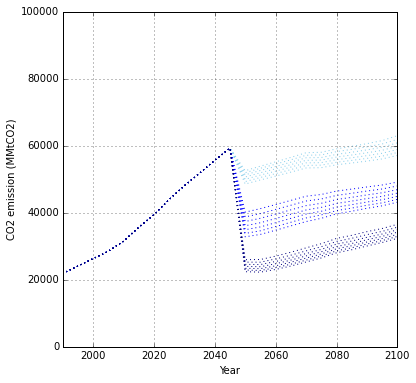

In [18]:
fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = qglobal_fos_step050
df1 = df1*0.5 #compensate for double count 
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='skyblue',linestyle=':')
df1 = qglobal_fos_step100
df1 = df1*0.5 #compensate for double count 
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='blue',linestyle=':')
df1 = qglobal_fos_step200
df1 = df1*0.5 #compensate for double count 
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='navy',linestyle=':')
ax1.set_ylabel('CO2 emission (MMtCO2)')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

(-4, 0)

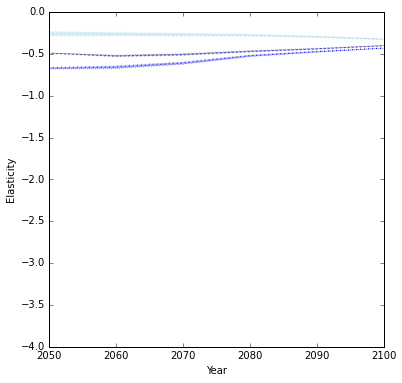

In [19]:
#fig = plt.figure(figsize=(3,8))

#ax1  = fig.add_subplot(211)
#fig = plt.figure(figsize=(3,8))
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_step050,qglobal_fos_step050)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='skyblue',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='skyblue',linestyle=':', alpha=0.3)   
elasticity_table = constructelasticity_table(p_step100,qglobal_fos_step100)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='blue',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='blue',linestyle=':', alpha=0.3)  
elasticity_table = constructelasticity_table(p_step200,qglobal_fos_step200)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='navy',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='navy',linestyle=':', alpha=0.3)          

ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [21]:
accumulated_elasticity(p_step050,qglobal_fos_step050)

[-0.28177276888709812, 0.015448566797230445]

In [22]:
accumulated_elasticity(p_step100,qglobal_tot_step100)

[-0.69430588497781187, 0.020946932023690246]

In [23]:
accumulated_elasticity(p_step200,qglobal_tot_step200)

[-0.77691049445824589, 0.01137321163291094]